In [1]:
import os
import re


import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

In [2]:
# Define colors for modes
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import seaborn as sns

MODE_COLORS = {"hard": "blue", "soft": "orange", "Weady et al.": "black"}
LINE_STYLES = {"$\\lambda = 10^{-2}$": "solid",
               "$\\lambda = 10^{-3}$": "dashed", "$\\lambda = 10^{-4}$": "dotted"}

In [3]:
from load_combined import load_combined

source_folders = [
    "../data/strong_scaling/",
 
]

# find recursive subfolders within source_folders
sim_dirs = []
for folder in source_folders:
    for root, dirs, files in os.walk(folder):
        # skip if /data as last part of path
        if "logs" in root or "data" in root.split(os.sep)[-1]:
            continue

        if any(f.endswith(".pvtu") for f in os.listdir(root)):
            sim_dirs.append(os.path.join(root))

particles_dict, sim_dict, params_dict = load_combined(sim_dirs, offset=-3)

loading ../data/strong_scaling/output_hard/8ranks/vtk_output_hard
loading ../data/strong_scaling/output_hard/112ranks/vtk_output_hard
loading ../data/strong_scaling/output_hard/24ranks/vtk_output_hard
loading ../data/strong_scaling/output_hard/48ranks/vtk_output_hard
loading ../data/strong_scaling/output_hard/2ranks/vtk_output_hard
loading ../data/strong_scaling/output_hard/96ranks/vtk_output_hard
loading ../data/strong_scaling/output_hard/4ranks/vtk_output_hard
loading ../data/strong_scaling/output_hard/1ranks/vtk_output_hard
loading ../data/strong_scaling/output_hard/16ranks/vtk_output_hard
loading ../data/strong_scaling/output_hard/64ranks/vtk_output_hard
loading ../data/strong_scaling/output_soft/8ranks/vtk_output_soft
loading ../data/strong_scaling/output_soft/112ranks/vtk_output_soft
loading ../data/strong_scaling/output_soft/24ranks/vtk_output_soft
loading ../data/strong_scaling/output_soft/48ranks/vtk_output_soft
loading ../data/strong_scaling/output_soft/2ranks/vtk_output_soft

In [4]:
# print sizte of particles_dict in MB
print(f"Loaded particles_dict with {particles_dict.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
print(f"Loaded sim_dict with {sim_dict.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
print(f"Loaded params_dict with {params_dict.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Loaded particles_dict with 2443.32 MB
Loaded sim_dict with 0.17 MB
Loaded params_dict with 0.01 MB


In [5]:
sim_dict

,iteration,simulation_time_s,time_since_last_log_s,step,num_particles,num_constraints,colony_radius,recursive_iterations,bbpgd_iterations,max_overlap,...,load_imbalance,dt_s,x,y,z,rank,Mode,Sensitivity,sim_dir,offset
0,0,0.000001,0.023244,0,1,0,0.25000,1,0,0.000000,...,8.00000,0.000001,NaN,NaN,NaN,0,hard,../data/strong_scaling/output_hard/8ranks/vtk_...,strong_scaling,0
1,1,2.405390,8.729950,8316,8,14,5.25294,1,20,0.000002,...,2.00000,0.000256,NaN,NaN,NaN,0,hard,../data/strong_scaling/output_hard/8ranks/vtk_...,strong_scaling,0
2,2,6.026990,19.957600,20643,256,2632,10.25380,3,60,0.000344,...,1.56250,0.000253,NaN,NaN,NaN,0,hard,../data/strong_scaling/output_hard/8ranks/vtk_...,strong_scaling,0
3,3,7.161720,22.708800,24941,1024,13453,15.25850,4,140,0.000607,...,1.44531,0.000326,NaN,NaN,NaN,0,hard,../data/strong_scaling/output_hard/8ranks/vtk_...,strong_scaling,0
4,4,7.777840,27.559900,27348,1985,20587,20.25860,3,120,0.000771,...,1.40655,0.000299,NaN,NaN,NaN,0,hard,../data/strong_scaling/output_hard/8ranks/vtk_...,strong_scaling,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,16,12.020300,418.414000,261130,63963,288129,80.25240,1,0,0.472061,...,1.55890,0.000012,NaN,NaN,NaN,0,soft,../data/strong_scaling/output_soft/64ranks/vtk...,strong_scaling,0
416,17,12.256700,506.717000,280960,76838,367159,85.25250,1,0,0.485571,...,1.61670,0.000012,NaN,NaN,NaN,0,soft,../data/strong_scaling/output_soft/64ranks/vtk...,strong_scaling,0
417,18,12.463300,518.608000,299415,85074,434804,90.25260,1,0,0.460073,...,1.61817,0.000011,NaN,NaN,NaN,0,soft,../data/strong_scaling/output_soft/64ranks/vtk...,strong_scaling,0
418,19,12.732100,793.693000,323875,101407,533723,95.25270,1,0,0.475481,...,1.54940,0.000011,NaN,NaN,NaN,0,soft,../data/strong_scaling/output_soft/64ranks/vtk...,strong_scaling,0


In [6]:
particles_dict["total_ranks"]=particles_dict["Sensitivity"].str.extract(r"(\d+)ranks")

In [7]:
from scipy.optimize import curve_fit

runtimes = []
for k, g in particles_dict.groupby(["Mode", "total_ranks"]):
    src = g["Sensitivity"].unique()[0]

    sim_data = sim_dict[sim_dict["Sensitivity"] == src]

    final_time = sim_data["cpu_time_s"].max()

    runtimes.append(pd.DataFrame({
        "Mode": [k[0]],
        "total_ranks": [int(k[1])],
        "runtime [h]": [final_time / 3600],
    }))
runtimes = pd.concat(runtimes, ignore_index=True)


def amdahl(N, p):
    return 1 / ((1 - p) + p / N)


def compute_speedup(group):
    baseline = group.loc[group["total_ranks"] == 1, "runtime [h]"].values[0]
    group = group.copy()
    group["speedup"] = baseline / group["runtime [h]"]

    N = group["total_ranks"].values
    S = group["speedup"].values

    # Fit p to all observed speedups
    popt, _ = curve_fit(amdahl, N, S, bounds=(0, 1))
    p_est = popt[0]

    group["amdahl"] = amdahl(N, p_est)
    group["p_est"] = p_est

    group["efficiency"] = group["speedup"] / group["total_ranks"]

    return group


runtimes = runtimes.groupby("Mode").apply(
    compute_speedup).reset_index(drop=True)

runtimes.sort_values(["Mode", "total_ranks"], inplace=True)
runtimes

/tmp/ipykernel_329067/2110830858.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  runtimes = runtimes.groupby("Mode").apply(


,Mode,total_ranks,runtime [h],speedup,amdahl,p_est,efficiency
0,hard,1,17.633000,1.000000,1.000000,0.944157,1.000000
3,hard,2,8.418972,2.094436,1.894220,0.944157,1.047218
5,hard,4,4.753528,3.709456,3.426036,0.944157,0.927364
8,hard,8,2.866250,6.151941,5.751658,0.944157,0.768993
2,hard,16,1.754064,10.052656,8.706772,0.944157,0.628291
4,hard,24,1.725494,10.219100,10.506056,0.944157,0.425796
6,hard,48,1.753369,10.056637,13.242706,0.944157,0.209513
7,hard,64,1.588942,11.097324,14.165152,0.944157,0.173396
9,hard,96,0.981261,17.969733,15.225729,0.944157,0.187185
1,hard,112,1.012897,17.408479,15.558559,0.944157,0.155433


In [8]:
def makeplot(data, x, y, xlabel=None, ylabel=None, outname=None, variable="density",
             xscale=None, yscale=None,
             **kwargs):

    fig, ax = plt.subplots(figsize=(10, 6))
    outname = outname or f"{y}_vs_{x}.png"

    sns.lineplot(data, x=x,                 y=y,
                 hue="Mode", marker="o", ax=ax, **kwargs, lw=2, ms=10, palette=MODE_COLORS, style_order=LINE_STYLES.keys())

    if xscale:
        ax.set_xscale(xscale, base=2)
    if yscale:
        ax.set_yscale(yscale, base=2)

    ax.set_xlabel(xlabel or x, fontsize=20)
    ax.set_ylabel(ylabel or y, fontsize=20)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid(True)
    ax.legend(fontsize=22)

    if outname:
        fig.savefig(outname, dpi=300, bbox_inches="tight")

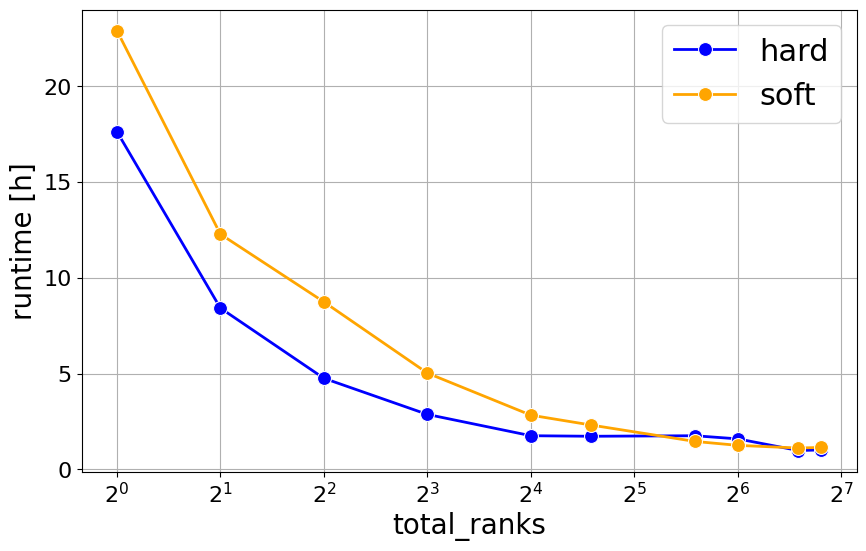

In [9]:
makeplot(runtimes, x="total_ranks", y="runtime [h]",
         outname="strong_scaling_hard_soft.png", xscale="log")

Mode,hard,soft,ratio soft/hard
total_ranks,,,
1,17.633000,22.907472,1.299125
2,8.418972,12.277944,1.458366
4,4.753528,8.741028,1.838851
8,2.866250,5.024583,1.753016
16,1.754064,2.827000,1.611686
24,1.725494,2.309425,1.338413
48,1.753369,1.456031,0.830419
64,1.588942,1.250533,0.787023
96,0.981261,1.111172,1.132392


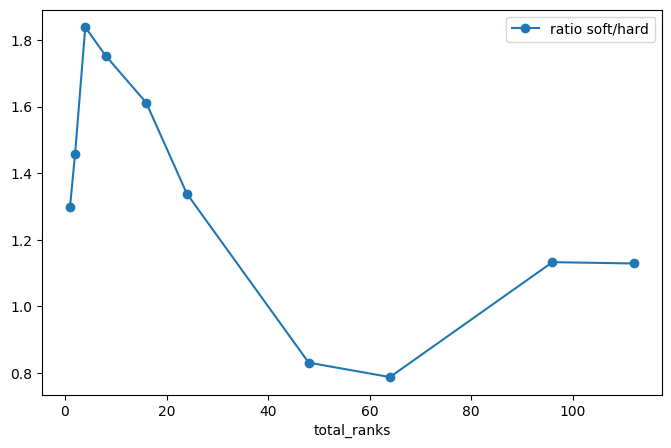

In [18]:
# comput runtuime hard / runtime soft
runtimes_pivot = runtimes.pivot(index="total_ranks", columns="Mode", values="runtime [h]")
runtimes_pivot["ratio soft/hard"] = runtimes_pivot["soft"] / runtimes_pivot["hard"]
runtimes_pivot.plot(y="ratio soft/hard", marker="o", figsize=(8,5))

# average
runtimes_pivot["ratio soft/hard"].mean()
runtimes_pivot

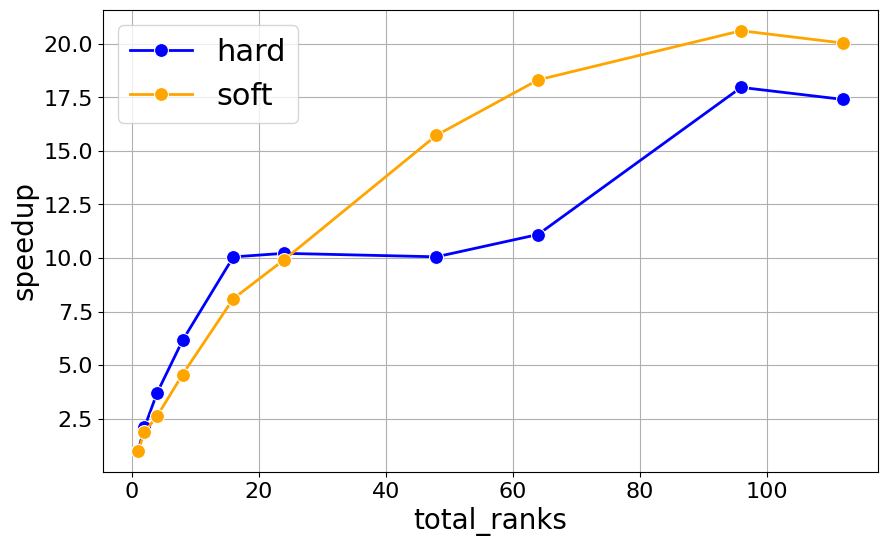

In [10]:
makeplot(runtimes, x="total_ranks", y="speedup",
         outname="strong_scaling_efficiency_hard_soft.png")

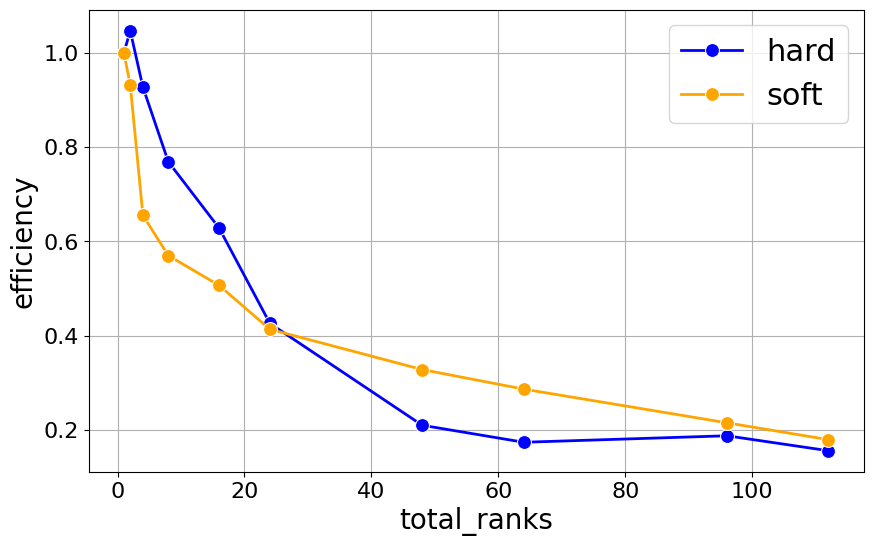

In [11]:
makeplot(runtimes, x="total_ranks", y="efficiency",
         outname="strong_scaling_efficiency_hard_soft_logx.png",
         )

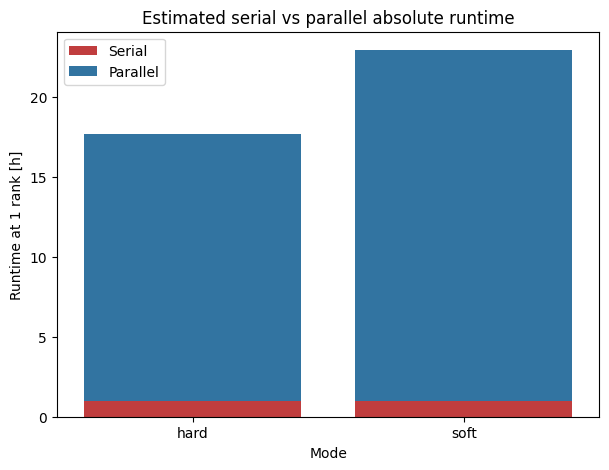

In [12]:
# Extract baseline runtimes and estimated p for each mode
baseline = runtimes[runtimes["total_ranks"] == 1].set_index("Mode")[
    "runtime [h]"]
p_by_mode = runtimes.groupby("Mode")["p_est"].first()

# Compute absolute contributions
df_plot = pd.DataFrame({
    "Mode": baseline.index,
    "serial_time": (1 - p_by_mode) * baseline,
    "parallel_time": p_by_mode * baseline
})

# Melt into tidy format
df_plot = df_plot.melt(id_vars="Mode",
                       value_vars=["serial_time", "parallel_time"],
                       var_name="component",
                       value_name="time [s]")

# Plot stacked bars with seaborn+matplotlib
plt.figure(figsize=(7, 5))
bottoms = df_plot[df_plot["component"] == "serial_time"].set_index("Mode")[
    "time [s]"]

# Plot serial (bottom layer)
sns.barplot(
    data=df_plot[df_plot["component"] == "serial_time"],
    x="Mode", y="time [s]", color="tab:red", label="Serial"
)

# Plot parallel (stacked on top)
sns.barplot(
    data=df_plot[df_plot["component"] == "parallel_time"],
    x="Mode", y="time [s]", color="tab:blue", label="Parallel",
    bottom=bottoms
)

plt.ylabel("Runtime at 1 rank [h]")
plt.title("Estimated serial vs parallel absolute runtime")
plt.legend(title="")
plt.show()